Value at risk (VaR) é uma forma de quantificar o risco para potenciais perdas de um investimento. Nos modelos de Markovitz ou o CAPM, as medidas que utilizamos são variância e desvio padrão para medir o risco, e beta para medir o risco de mercado. No entanto, nenhuma dessas métricas considera a distribuição de probabilidade. O método utilizando Monte Carlo é a solução de um sistema de equações diferencias através do Wiener-process:
$$ dS(t) = \mu S(t) dt + \sigma S(t) dW $$

$$ S(t) = S(0) e^{[(\mu - 0.5 \sqrt{\sigma})t + \sigma \sqrt{t} N(0,1)]} $$


onde S é o valor do investimento, $ \mu $ é a média dos retornos diários, $ \sigma $ é o desvio padrão diário, $ \delta t $ é a quantidade de dias e $ N(0,1) $ é a distribuição normal com média zero e variância 1.

Na simulação de Monte Crlo, são gerdadas uma grande quantidade de estimativas pra os preços das ações com essa equação. Os resultados são ordenados do menor para o maior para calcular o intervalo de confiança.

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import datetime

In [2]:
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2022, 2, 4)
stocks = ['AAPL', 'TSLA', 'AMZN', 'FB']

## Download dos dados

In [3]:
data = {}

for stock in stocks:
    ticker = yf.download(stock, start_date, end_date)
    data[stock] = ticker['Adj Close']
stock_data = pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

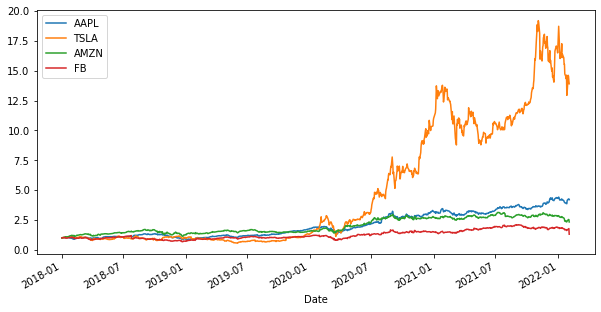

In [4]:
(stock_data / stock_data.iloc[0]).plot(figsize=(10,5))

## Cálculo dos retornos

In [5]:
returns = {}

for stock in stocks:
    returns[stock] = stock_data[stock].pct_change()

returns = pd.DataFrame(returns)
returns = returns[1:]

returns

,AAPL,TSLA,AMZN,FB
Date,,,,
2018-01-03,-0.000174,-0.010233,0.012775,0.017914
2018-01-04,0.004645,-0.008290,0.004476,-0.001841
2018-01-05,0.011385,0.006230,0.016163,0.013671
2018-01-08,-0.003714,0.062638,0.014425,0.007653
2018-01-09,-0.000115,-0.008085,0.004676,-0.002178
...,...,...,...,...
2022-01-28,0.069778,0.020806,0.031084,0.023995
2022-01-31,0.026126,0.106776,0.038864,0.038282
2022-02-01,-0.000973,-0.005839,0.010831,0.018323


## Cálculo do valor em risco

In [6]:
S = 1e4 # valor do investimento
c = 0.95 # intervalo de confiança
n = 1 # no dia seguinte
iterations = 10000 # número de simulações de Monte Carlo

In [7]:
var = {}

for stock in stocks:
    
    # podemos supor que os retornos diários sejam normalmente distribuídos:
    mu = np.mean(returns[stock])
    sigma = np.std(returns[stock])

    # criando as simulações:
    rand = np.random.normal(0, 1, [1, iterations])

    # equação para o preço das ações S(t)
    # o random walk do nosso investimento inicial
    stock_price = S * np.exp(n * (mu - 0.5 * sigma **2) + sigma * np.sqrt(n) * rand)

    # temos que ordenar os preços das ações para determinar o percentagem
    stock_price = np.sort(stock_price)

    # depende do nível de confiança: 95% -> 5% and 99% -> 1
    percentile = np.percentile(stock_price, (1 - c) * 100) # Calcular o percentil q dos dados ao longo do eixo especificado

    # a perda máxima possível tem algo a ver com a simulação que tem o menor valor
    var[stock] = S - percentile

In [8]:
tabela_var = pd.DataFrame(var.items(), columns=['stock', 'var'])
tabela_var.index = tabela_var['stock']
tabela_var.drop(['stock'], axis =1)

,var
stock,
AAPL,322.700002
TSLA,639.944381
AMZN,311.340277
FB,386.182030


<AxesSubplot:xlabel='stock'>

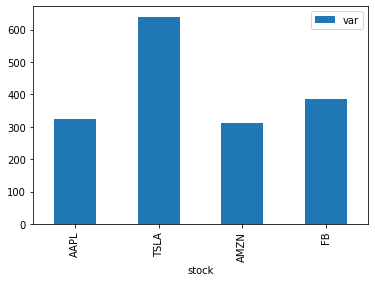

In [9]:
tabela_var.plot.bar()